# Advanced Lane-Line
The following notebook contains sample imagery, descriptions, and simple templated sources. It cannot stand without the accompanying sources in this repository.

In [1]:
import os
import cv2
import matplotlib
import pandas as pd
from scipy import misc
from moviepy.editor import VideoFileClip

%matplotlib inline

%run src/util.py
%run src/viz.py

print("Loaded external sources.")

Loaded external sources.


## Test Images

The test images provide a number of different views of the road surface, under somewhat varried conditions. They also serve to highlight a number of possible difficulties with a detection pipeline which must account for (1) The presence of other vehicles, (2) Varrying road conditions (3) Varrying lighting conditions, (4) Road curvature. In this case, the weather is uniform (indeed, 'the sunny day in California') but more care and attention would be required if the provided videos included rain, snow, ice etc. The helper function used for visualization, `mosaic`,  is defined in `src/viz.py`.  

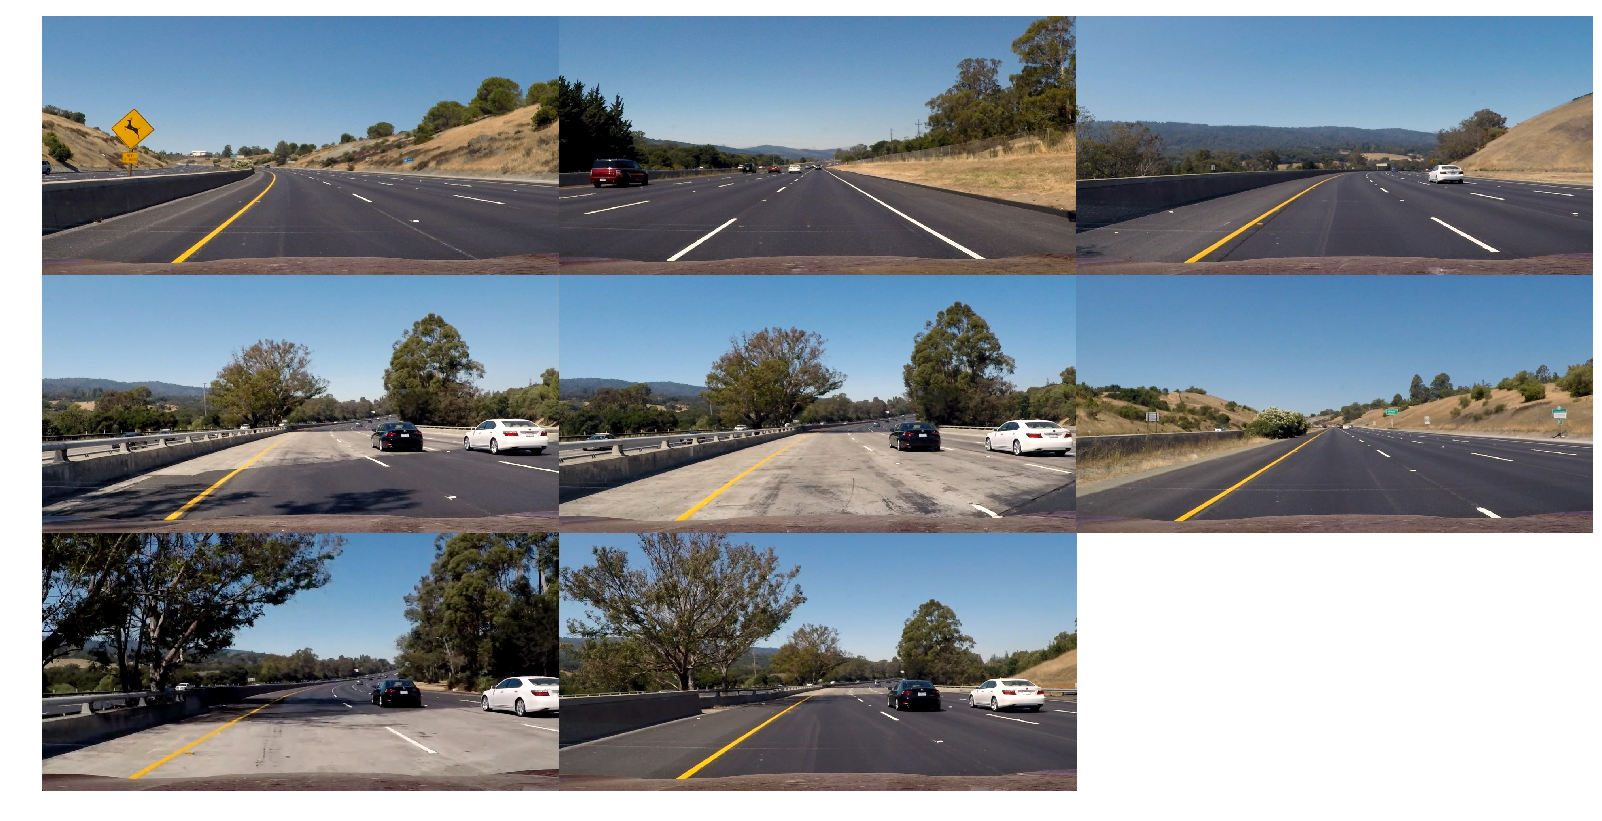

In [2]:
# The test images are loaded into memory (there is sufficient memory).
test_images = [misc.imread(image_path) for image_path in abswalk('./test_images')]

# A view of the original test images.

figure_1 = mosaic(test_images, 10, 20, 3)
figure_1.show()


**Figure 1** Unaltered test images. Note differences in lighting, and in the coloration of the road surface. 

## Camera calibration
Relevant sources are in `calibrator.py`. Tha calibration mapping is determined based on chessboard images, shown after calibration in *Figure 3*. The procedure depends heavily on the OpenCV methods `findChessboardCorners` and `drawChessboardCorners` which greatly facilitate this common image manipulation/preprocessing task. *Figure 2* shows the result of applying the calibration mapping to the test images. 

N/A% (0 of N/A) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Preparing calibrator.


100% (20 of 20) |#########################| Elapsed Time: 0:00:11 Time: 0:00:11


Calibrator prepared.


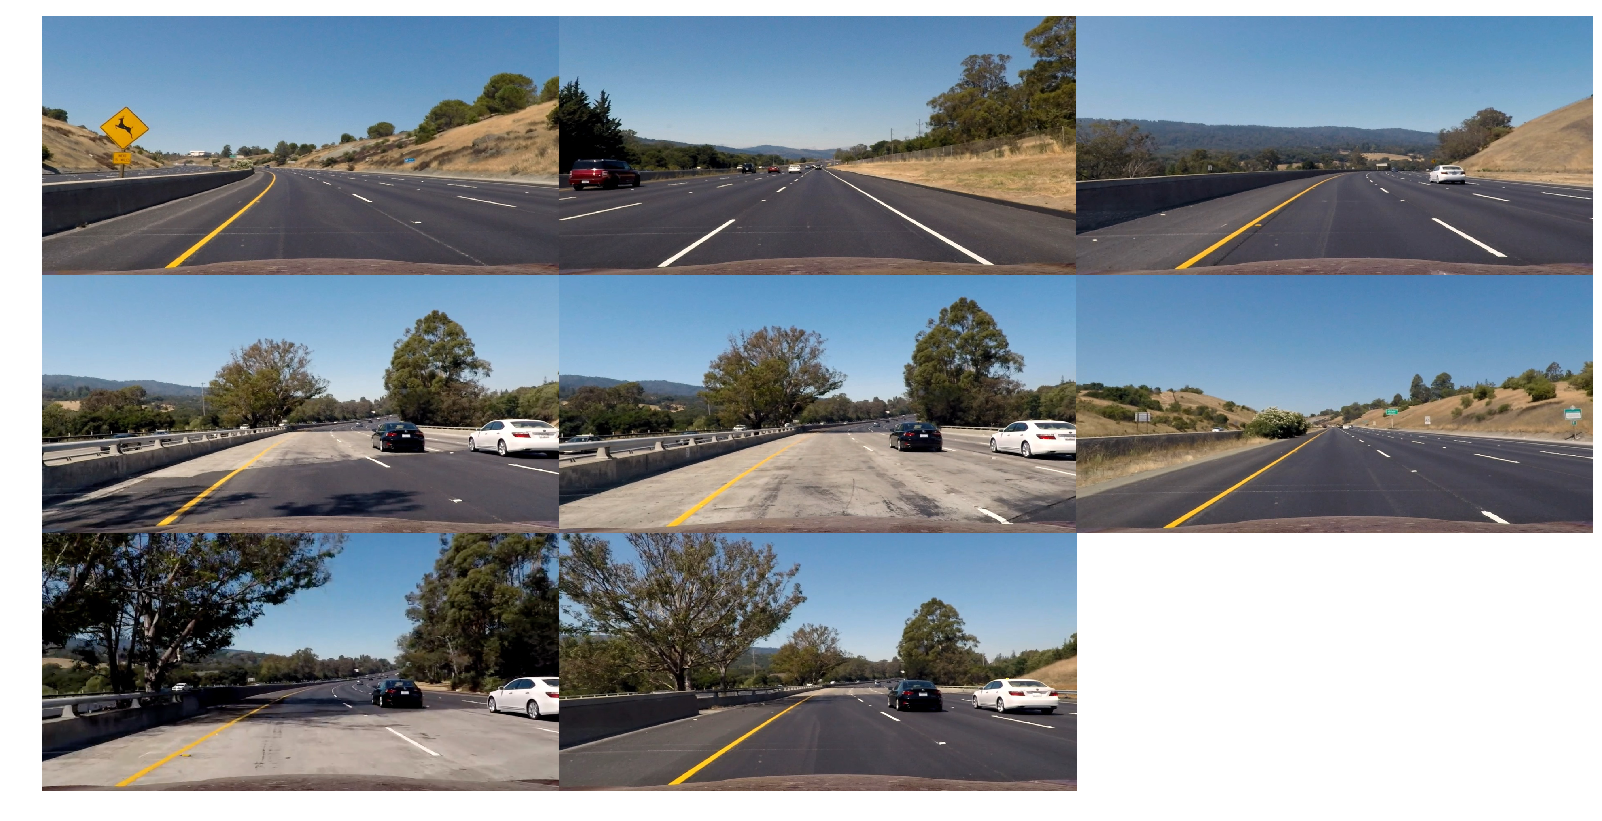

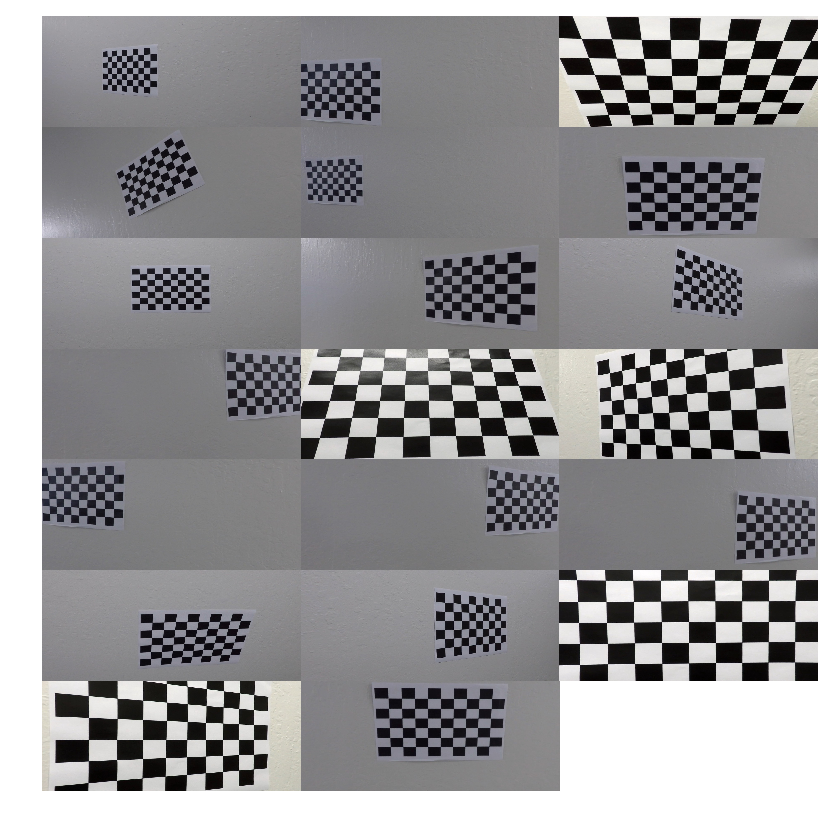

In [3]:
%run src/calibrator.py

calibration_image_paths = abswalk('camera_cal')
calibration_images = [misc.imread(image_path) for image_path in calibration_image_paths]

# See calibrator.py for details of this class.
print("Preparing calibrator.")
cal = Calibrator((9,6), calibration_image_paths)
print("Calibrator prepared.")

calibrated_test_images = [cal.undistort(image) for image in test_images]

figure_2 = mosaic(calibrated_test_images, 10, 20, 3)
figure_2.show()

calibrated_cal_images = [cal.undistort(image) for image in calibration_images]

figure_3 = mosaic(calibrated_cal_images, 10, 10, 3)
figure_3.show()


** Figures 2,3** Camera calibration. Figure 2, the top panel, shows the test images after calibration. Fiture 3 shows the chessboard images, after calibration, from which the caslibration mapping is determined. 

## Perspective alteration
Relevant sources are in `perspectifier.py`. The source and image points are selected from the image
`straight_lines1.jpg`. 

A perspective transform enables the isolation of the road surface, viewed top down, from the rest of the image. *Figure 4* below, top panel, shows the image from which source points were selected. The region bounded by these points is transformed to a vertical plane, where determining the pixels which make up a lane line, and fitting a polynomial to each lane line is much more straightforward. 

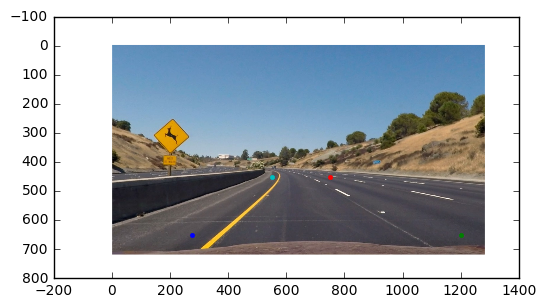

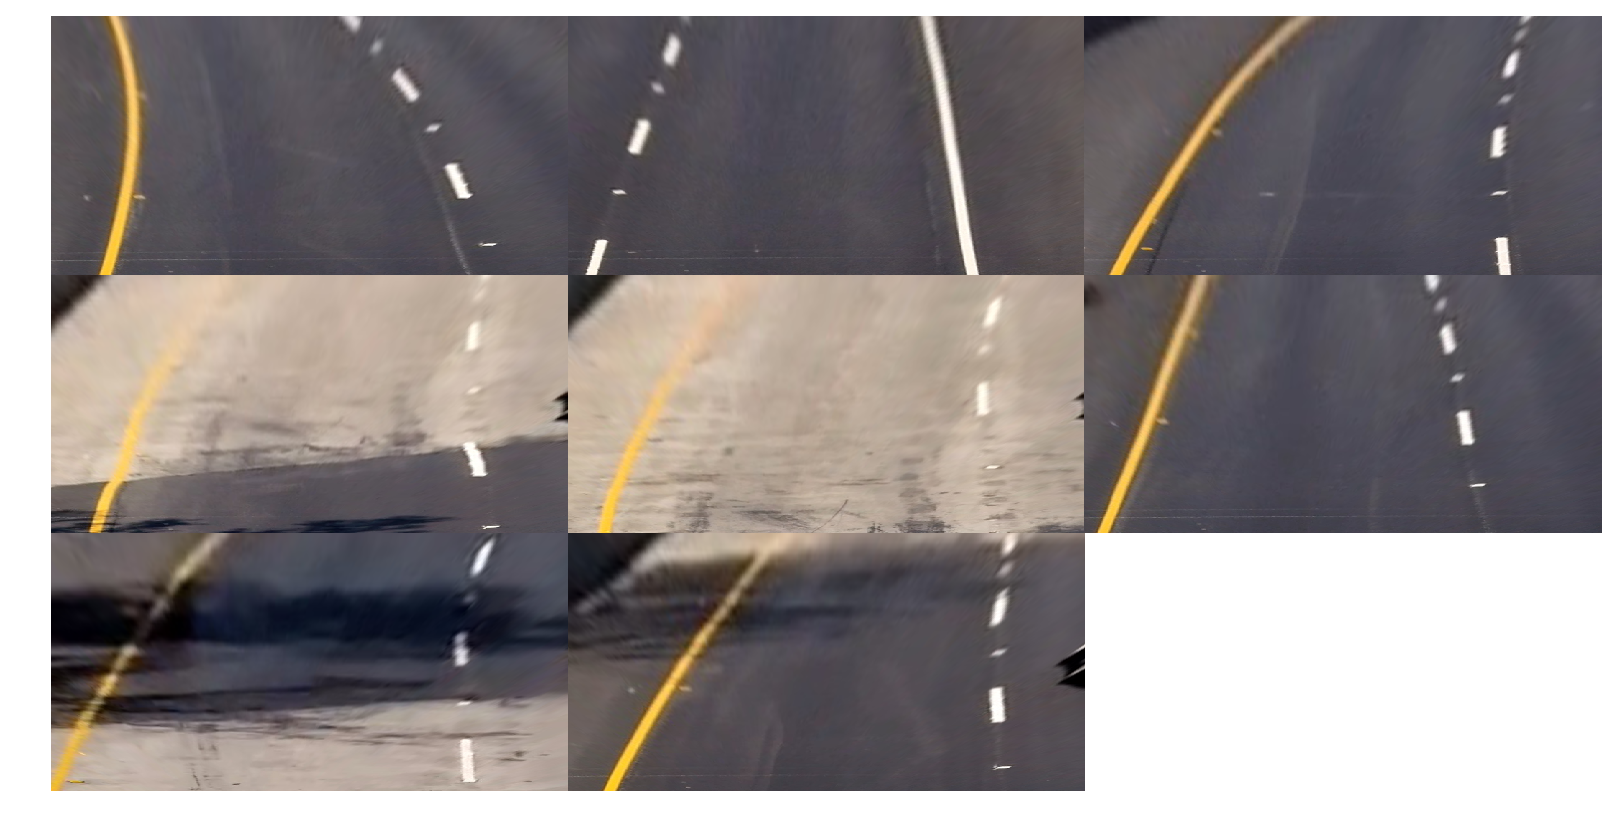

In [4]:
%run src/perspectifier.py

image_shape = test_images[0].shape

source_points = np.array([[275, 650], [1200,650], [750, 450], [550, 450]], np.float32)
destination_points = np.array([[0, image_shape[1]],
                                [image_shape[0], image_shape[1]],
                                [image_shape[0], 0], 
                                [0, 0]], np.float32)
plt.imshow(calibrated_test_images[0])
for point in source_points:
    plt.plot(point[0], point[1], '.')

# See perspectifier.py for details of this class
per = Perspectifier(source_points = source_points, destination_points = destination_points)

per_test_images = [per.perspectify(image) for image in calibrated_test_images]
figure_4 = mosaic(per_test_images, 10, 20, 3)
figure_4.show()

**Figure 4** The perspective transform. The fource source points are shown in the top panel, for the top left image in the mosaic below. The sample points are successfuly used for all test images. The mosaic in the bottom panel shows the result of applying the perspective transform to all test images. 

## Further pre-processing 
Aside from the above transforms, the images on which lane lines are to be detected are pre-processed as follows: 

- Contrast Limited Adaptive Histogram Equalization (CLAHE) 
- Guassian normalization 
- Conversion to HLS color space and extraction of the S channel 
    - Sobel (x) 
    - Sobel (y) 

** The procedure returns two images: the gradient in the x direction, and the gradient in the y direction of the S-channel of the HLS representation of the image.** This procedure allows us to make use of color information encapsulated in the S channel, more elegantly than combinations of arbitrary thresholds. *The fewer magic numbers we need, the better*. CLAHE is applied as a first step, prior to a Gaussian filter. 

Further details are in the `preprocess.py` module.

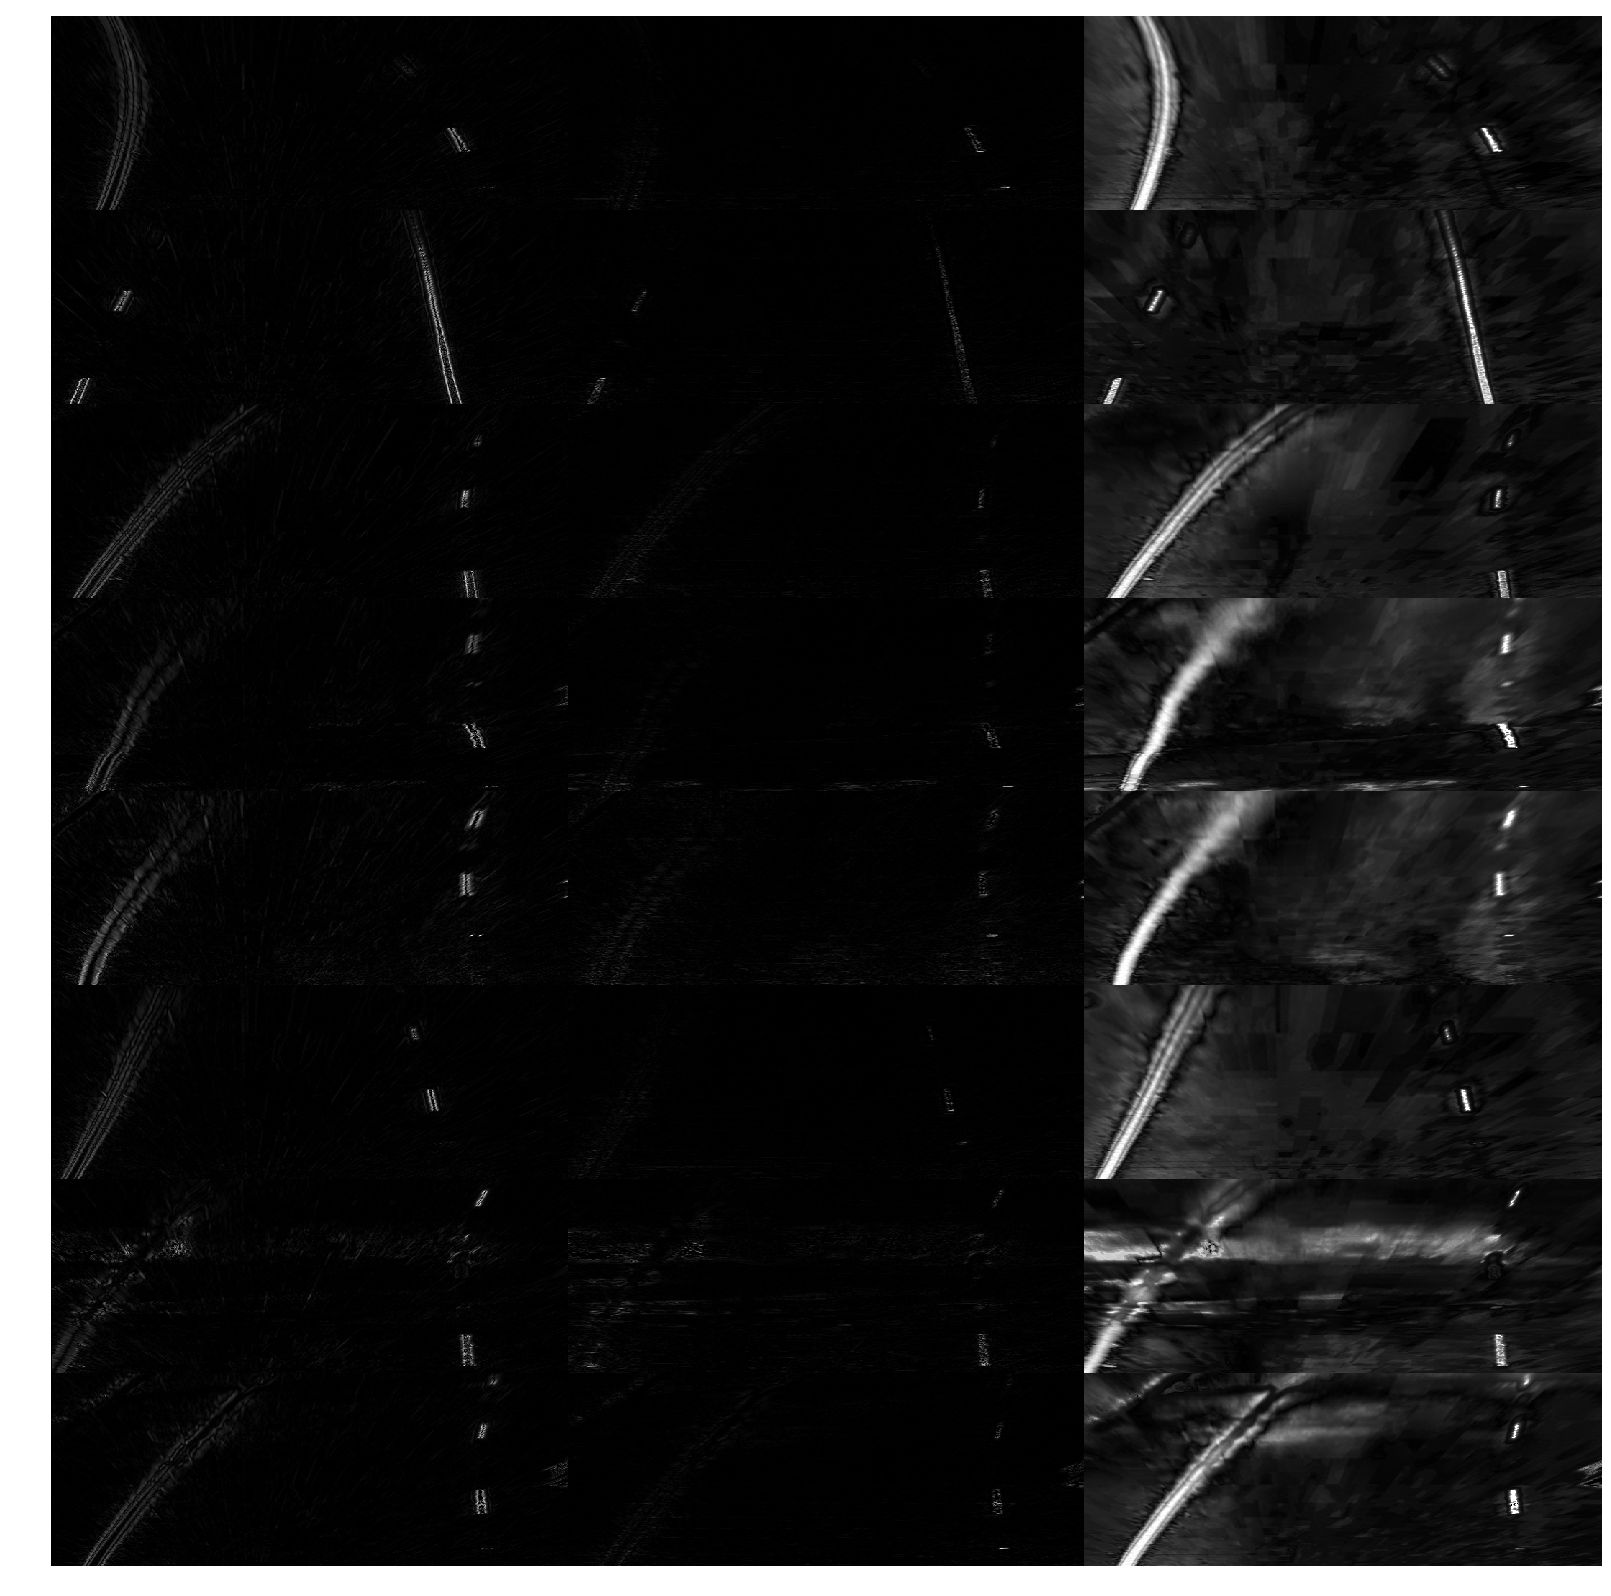

In [5]:
%run src/preprocess.py

proc_test_images = [preproc(image) for image in per_test_images]

plot_proc_test_images = [image for image_set in proc_test_images for image in image_set]
figure_5 = mosaic(plot_proc_test_images, 20, 20, 3, cmap='gray')
figure_5.show()


** Figure 5** Above, each row pertains to a separate test image. The columns, from left to right, contain (1) The scaled, absolute value of the gradient in the x direction, (2) The scaled, absolute value of the gradient in the y directon, and (3) The S-channel of test image. CLAHE is applied before the computation of (1), (2), and (3). 

## Thresholding 

With the above images as starting points, hresholds are applied to the gradients in the x and y direction, and the union of the results gives the final image input to the pipeline that follows. **The gradient operation is applied to the S-channel of the input image, and not to a grayscale version.** This prevents total loss of color information. Through experimentation, it was determined that this procedure provided better results than a number of operations where the gradients of a grayscale image, and the s-channel, were considered seperately as in the lessons. 

Thresholding requires simple helper sources in `threshold.py`. 

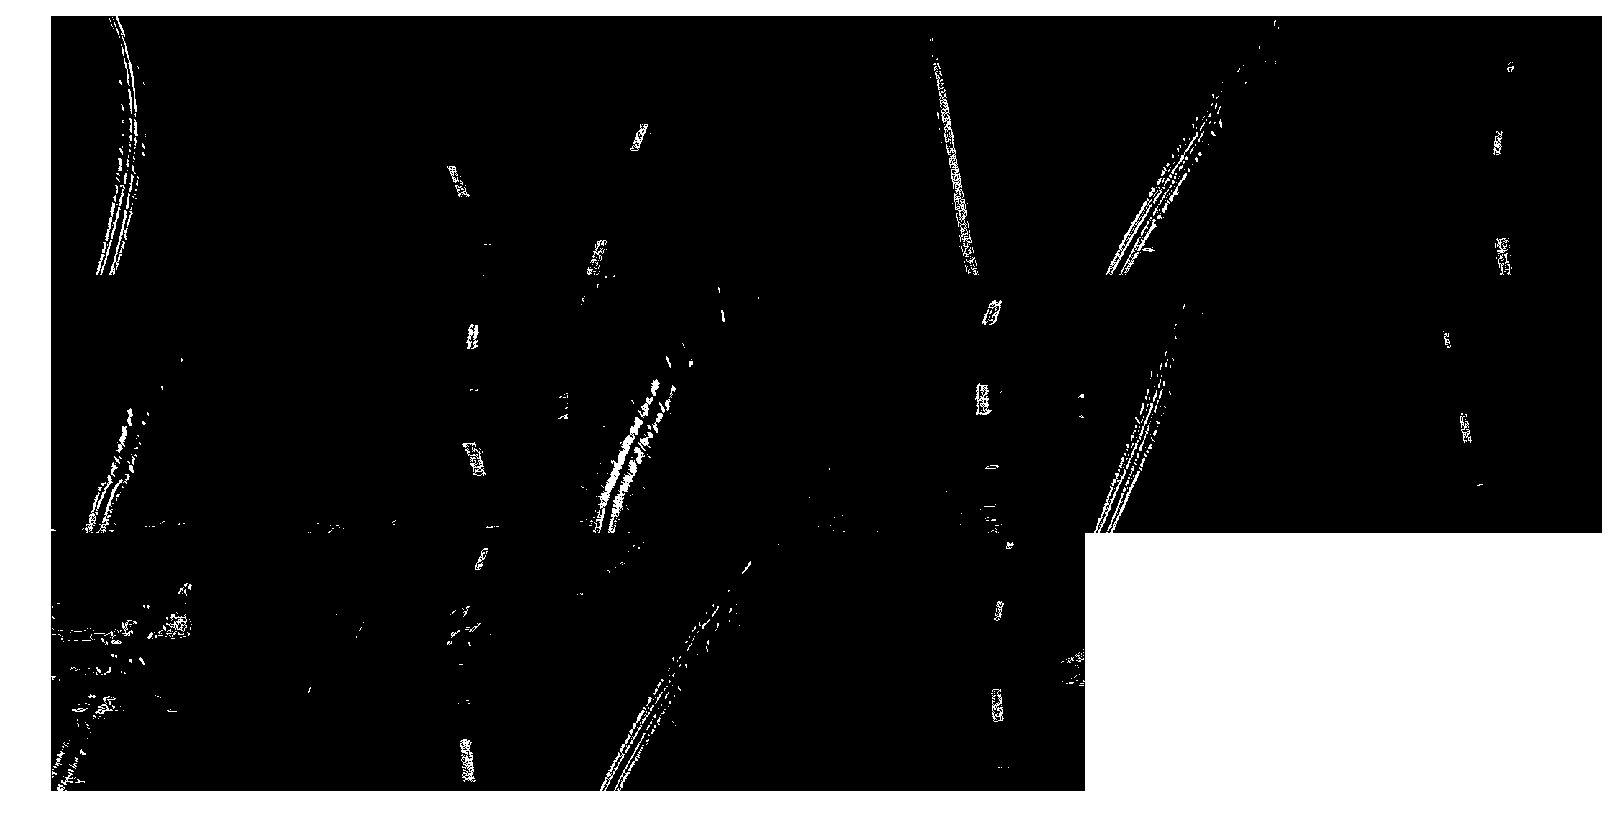

In [6]:
# Compute the magnitude and direction of the test iamge gradients.
%run src/treshold.py
import numpy as np

test_image_dx   = [sx for sx, _, _, in proc_test_images]
test_image_dy   = [sy for _, sy, _, in proc_test_images]

dx   = [bithreshold(image, 40, 100, '>=', '<=') for image in test_image_dx]
dy   = [bithreshold(image, 40, 100, '>=', '<=') for image in test_image_dy]

f2 = np.array([dxi | dyi for dxi, dyi in zip(dx, dy)], dtype=np.uint8)
mosaic(f2, 10, 20, 3, cmap='gray').show()


**Figure 6**  Union of the gradient for the S-channel in the x direction, and the gradient of the S-channel in the y direction, after the application of thresholds (see above.)

##  Lane Detection 

Sources relevant to what follows are contained in `line.py`, which defines the parameters required to identify a lane line, and `laneomatic.py` which defines the detection pipeline based on sliding windows, for primary detection. In the sections that follow, the lane detection is separated into two phases: 

1. Primary Detection - based on sliding windows, to be used for still images, or the first frame of video.
2. Secondary Detection - to take place after primary detection, when a lane-line has already been detected in a previous frame of video. 

### Primary Detection 

Primary detection is applied to still images, or the first frame of video images. This approach uses histogram analysis to initialize a sliding window search for pixels likely to be part of lane lines. A second-degree polynomial is then fit to each potential lane marker. After the centroid of the first two windows (left lane, right lane) is defined, the image is scanned vertically and the window centroids are updated based on the concentration of highlighted pixels, which we assume to be part of lane lines. 
 

In [7]:
%run src/laneomatic.py

lane_detector = LaneOMatic(primary_only=True)

sw_lanes = [lane_detector.detect_lanes(image, image_only=True) for image in f2]
mosaic(sw_lanes, 10, 20, 3).show()

** Figure 7** Primary lane line detection. Windows are (obviously) outlined in green. Pixels determined to be part of the left lane are highlighted in red, and pixels determined to be part of the right lane are highlighted in blue. The yellow lines show the quadratic polynomial fit to each lane line. 

### Secondary Detection and Application to Video

Secondary detection is only applicable to the analysis of video streams - given the polynomials defining the left and right lane lines obtained from the primary detection phase, a boundary is applied around the polynomial and its parameters are updated based on the pixels within that boundary which appear to be part of a lane line. Exponential smoothing is applied to the parameters. 

Prior to the application of this procedure, a template method is defined below, enabling the application of the detecton procedure to video streams. 

In [8]:
# The calibrator, perspective transform etc. are defined earlier in the notebook. We apply the same defaults here. 
class CurvatureCollector:
    def __init__(self): 
        self.left_curvatures = []
        self.right_curvatures = []

curvature_accumulator = CurvatureCollector()

def build_processor(calibrator=cal, perspectifier=per, preprocessor=preproc, 
                    detector=LaneOMatic(), curv_acc=curvature_accumulator, overlay=False): 
    def processor(image): 
        image_undistorted = cal.undistort(image)
        image_working = per.perspectify(image_undistorted)
        dx, dy, _ = preproc(image_working)

        ## Recall that we are taking the gradient of the s-channel here  
        dx   = bithreshold(dx, 40, 100, '>=', '<=') 
        dy   = bithreshold(dy, 40, 100, '>=', '<=') 

        image_working = (dx | dy) 
    
        left_fit, left_curvature, right_fit, right_curvature, output_image = detector.detect_lanes(image_working)
    
        curv_acc.left_curvatures.append(left_curvature)
        curv_acc.right_curvatures.append(right_curvature)
        
        if overlay: 
            overlay_image = lane_overlay(output_image, left_fit, right_fit)
            overlay_image = per.unperspectify(overlay_image)
            output_image = cv2.addWeighted(image_undistorted, 1, overlay_image, 0.3, 0)
            
        return output_image
    return processor 

In [9]:
video0_output = 'project_video_testing.mp4'
processor = build_processor()

video0 = VideoFileClip("project_video.mp4")
video0_processed = video0.fl_image(processor)

%time video0_processed.write_videofile(video0_output, audio=False)

[MoviePy] >>>> Building video project_video_testing.mp4
[MoviePy] Writing video project_video_testing.mp4


100%|█████████▉| 1260/1261 [06:15<00:00,  3.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_testing.mp4 

CPU times: user 31min 13s, sys: 34.5 s, total: 31min 47s
Wall time: 6min 16s


The output file, `project_video_testing.mp4` shows the equivalent of *Figure 7* in video form. Below is a discussion of lane curvature. 

### Curvature

Lane curvature is expected to be on the order of 1km, it is visualized below. 

In [10]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

curvature_data = pd.DataFrame({"left_curvature"   : [np.log2(x) for x in curvature_accumulator.left_curvatures], 
                               "right_curvature" : [np.log2(x) for x in curvature_accumulator.right_curvatures],
                               "time" : range(len(curvature_accumulator.left_curvatures))})

figure_8 = plt.figure()

ax = figure_8.add_subplot(111)
ax.plot(curvature_data.left_curvature, curvature_data.time, 'r.', alpha=0.5)
ax.plot(curvature_data.right_curvature, curvature_data.time, 'b.', alpha=0.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.yaxis.grid("major")

ax.xaxis.set_ticks_position('bottom')

ax.set(title='Lane Curvature', xlabel='log2(curvature)', ylabel='Video Frame')

figure_8.show()

**Figure 8** A visualization of lane curvature in the project video. Curvature of the left lane is shown in red, and curvature of the right lane is shown in blue. Video frames (a surrogate for time) are plotted along the vertical axis, and curvature is plotted along the horizontal axis. The base-2 log of curvature is plotted here to avoid excessive skewing of the plot by curvature values representing the transition from a left to a right turn in the project video.  

The major curves in the highway on which the project video is filmed, the first to the left, and the second to the right, occur between frames [0, 200] and frames [600, 1200], respectively. Elsewhere, in frames [200, 600] and the concluding frames, the road becomes straight. In the major curves, as shown abouve lies between approximately 1024m (1km) and 4096m (4km), a reasonable result considering that the approach here is somewhat 'rough and ready,' whose main purpose is educational. Furthermore, the curvature of the left and right lane lines is generally very similar in each frame, indicating that the lane lines are, at least relatively, being identified sensibly. 

### Video Overlay 

As a step, lane lines are drawn on the calibrated video. See the template method for image processing described above. 

In [11]:
video0_output = 'project_video_final.mp4'
processor = build_processor(overlay=True)

video0 = VideoFileClip("project_video.mp4")
video0_processed = video0.fl_image(processor)

%time video0_processed.write_videofile(video0_output, audio=False)

[MoviePy] >>>> Building video project_video_final.mp4
[MoviePy] Writing video project_video_final.mp4


100%|█████████▉| 1260/1261 [06:59<00:00,  2.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_final.mp4 

CPU times: user 34min 29s, sys: 36.3 s, total: 35min 5s
Wall time: 7min 1s


## Concluding Discussion 



The pipeline implemented here enjoys moderate success. As discussed above, curvature values are reasonable in the large left and right curves at the beginning and the conclusion of the video. 

A major shortcoming of this procedure is the region of interest applied to identifiy the lane lines. While it is approriate for the test images and for the project video, in situations where the vehicle is on an incline, or where the width of lanes is different, this would not be appropriate, and a more automated approach would be warranted.

Furthermore, the presence of other vehicles directly ahead of the camera is not a concern in the main testing footage, or any of the test images, but would certainly present a difficulty in real conditions.

In general, approaches based on thresholds, and 'magic numbers,' which do not adapt based on changing circumstances, are not appropriate for general use. While it was not part of the scope of this experiment, the incorporation of some limited machine learning and statistical modelling, or at the very least, more dynamic thresholding, would make the lane detection pipeline far more robust. This touches on an important criticism of the model applied here: it does not include a notion of certainty/uncertainty. Further development of this project could include the notion of 'goodness of fit' and other metrics, to 

For further improvement, it may be worthwhile to implemente a look-back procedure more complex than the simple exponential smoothing applied to the parameters of the two quadratic fits here. If the resources are available, more robust procedures operating on buffers of a set number of past frames, would likely produce better results. Also, while a quadratic model is convenient, a more advanced approach to defining the space ahead of the vehicle could easily be devised. For example, the use of LOESS curves to define lane lines may lead to a more accurate fit.